# Logistic Regression Modellemesi (Target 1 - Dengeli Veri)

Bu bölümde, sınıf dengesizliği giderilmiş (balanced) veri seti üzerinde **Logistic Regression** algoritmasının performansı analiz edileceğim.

**Adımlar:**
1.  **Veri Hazırlığı:** Parquet formatındaki verinin yüklenmesi ve ölçeklendirilmesi (Scaling).
2.  **Naive (Taban) Model:** Hiçbir ayar yapılmadan ham performansın ölçülmesi.
3.  **Hiperparametre Optimizasyonu:** `GridSearchCV` ile en iyi `C` (Regularization) değerinin bulunması.
4.  **Sınıf Ağırlıklandırma (Class Weighting):** "Orta Seviye" (Class 1) başarısını artırmak için ağırlık denemeleri.
5.  **Katsayı Analizi (Feature Importance):** Modelin hangi özelliklere önem verdiğinin görselleştirilmesi.

In [24]:
# Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model ve Ön İşleme Araçları
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. VERİYİ YÜKLEME
# target2_data.parquet dosyasını (Estimated Owners hedefli veri) kullanıyoruz
try:
    df = pd.read_parquet("target1_data.parquet")
    X = df.drop(columns=['target_new'])
    y = df['target_new']
    
    # 2. VERİYİ BÖLME (%80 Eğitim, %20 Test)
    # stratify=y komutu, eğitim ve test setindeki Low/Medium/High oranlarının aynı olmasını sağlar.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Veri Hazır!")
    print(f"Eğitim Seti: {X_train.shape}")
    print(f"Test Seti:   {X_test.shape}")

except FileNotFoundError:
    print("HATA: 'target2_data.parquet' dosyası bulunamadı.")

Veri Hazır!
Eğitim Seti: (49145, 40)
Test Seti:   (12287, 40)


## 2. Naive (Referans) Model Kurulumu

Herhangi bir hiperparametre ayarı veya sınıf ağırlıklandırması yapmadan önce, modelin **taban performansını (baseline)** görmek için standart bir Logistic Regression modeli kuruyoruz.

* **Not:** Logistic Regression uzaklık temelli çalıştığı için veriler `StandardScaler` ile ölçeklendirilecektir.


NAIVE (TABAN) LOGISTIC REGRESSION SONUCU
Doğruluk (Accuracy): %90.10
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4056
           1       0.85      0.85      0.85      4054
           2       0.96      0.95      0.95      4177

    accuracy                           0.90     12287
   macro avg       0.90      0.90      0.90     12287
weighted avg       0.90      0.90      0.90     12287



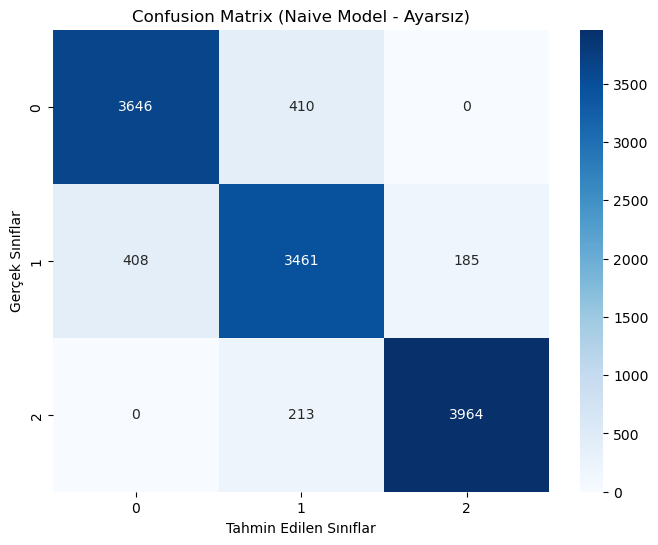

In [25]:
# 2. NAIVE LOGISTIC REGRESSION (Referans Model)
# Amaç: Hiçbir özel işlem yapmadan modelin ham performansını görmek.

# Logistic Regression sayıların büyüklüğünden etkilendiği için standartlaştırma şarttır.
scaler = StandardScaler()

# Eğitim setine göre fit ediyoruz (öğreniyoruz), test setini sadece dönüştürüyoruz.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# class_weight=None (Varsayılan) -> Model sınıf dengesizliğini umursamayacak.
naive_model = LogisticRegression(random_state=42, max_iter=1000)

naive_model.fit(X_train_scaled, y_train)

# C. Tahmin
y_pred_naive = naive_model.predict(X_test_scaled)

# D. Sonuçları Raporlama
print("\nNAIVE (TABAN) LOGISTIC REGRESSION SONUCU")
print(f"Doğruluk (Accuracy): %{accuracy_score(y_test, y_pred_naive)*100:.2f}")
print("-" * 60)
print(classification_report(y_test, y_pred_naive))

# E. Görselleştirme (Confusion Matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_naive), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Naive Model - Ayarsız)')
plt.ylabel('Gerçek Sınıflar')
plt.xlabel('Tahmin Edilen Sınıflar')
plt.show()

## 3. Hiperparametre Optimizasyonu (GridSearch)

Logistic Regression'ın genelleme yeteneğini artırmak için **C (Regularization Strength)** parametresini optimize ediyoruz.
* **C Değeri:** Küçüldükçe model daha basit (genel) olur, büyüdükçe veriye daha çok uyar (overfit riski artar).

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/iremkeser/Desktop/anaconda3/envs/steam/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/iremkeser/Desktop/anaconda3/envs/steam/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/iremkeser/Desktop/anaconda3/envs/steam/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification i


En İyi Parametreler: {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}
En İyi Skor: %89.4984

OPTİMİZE EDİLMİŞ LOGISTIC REGRESSION SONUCU
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4056
           1       0.85      0.86      0.85      4054
           2       0.96      0.95      0.95      4177

    accuracy                           0.90     12287
   macro avg       0.90      0.90      0.90     12287
weighted avg       0.90      0.90      0.90     12287



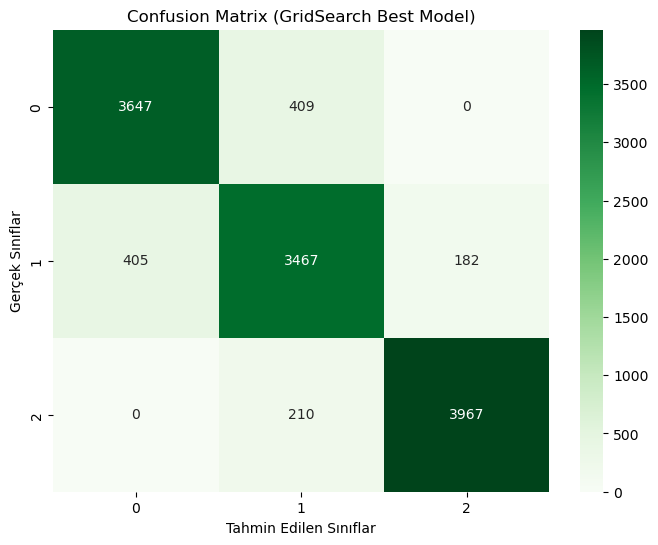

In [26]:
from sklearn.model_selection import GridSearchCV

# 1. Parametre Izgarasını Belirle
# C: Düzenlileştirme gücü (Küçük değer = Güçlü düzenlileştirme / Büyük değer = Zayıf düzenlileştirme)
# penalty: l1 (Lasso) veya l2 (Ridge)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'], # Algoritma çözücüleri
    'max_iter': [1000, 2000]
}

# 2. GridSearch Modelini Kur
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=5,            # 5 katlı çapraz doğrulama
    scoring='accuracy', # Genel doğruluğu maksimize etmeye çalışıyoruz
    n_jobs=-1,       # Tüm işlemciyi kullan
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

# 3. En İyi Sonuçları Göster
print(f"\nEn İyi Parametreler: {grid_search.best_params_}")
print(f"En İyi Skor: %{grid_search.best_score_*100:.4f}")

# 4. En İyi Model ile Test Seti Tahmini
best_log_reg = grid_search.best_estimator_
y_pred_best = best_log_reg.predict(X_test_scaled)

print("\nOPTİMİZE EDİLMİŞ LOGISTIC REGRESSION SONUCU")
print(classification_report(y_test, y_pred_best))

# 5. Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (GridSearch Best Model)')
plt.ylabel('Gerçek Sınıflar')
plt.xlabel('Tahmin Edilen Sınıflar')
plt.show()

## 4. Sınıf Ağırlıklandırma (Class Weight Tuning)

Modelin **Class 1 (Orta Seviye)** sınıfındaki başarısını (Recall) artırmak amacıyla, bu sınıfa yapılan hataların cezasını artırarak modelin dikkatini bu yöne çekiyoruz.

Farklı ağırlık senaryoları test edilip en iyi dengeyi sağlayan seçilecektir.

Fitting 3 folds for each of 10 candidates, totalling 30 fits

En İyi Ağırlık Ayarı: None

En İyi C Değeri: 0.1
En İyi Skor: %89.4985

AĞIRLIKLI LOGISTIC REGRESSION SONUCU
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4056
           1       0.85      0.85      0.85      4054
           2       0.96      0.95      0.95      4177

    accuracy                           0.90     12287
   macro avg       0.90      0.90      0.90     12287
weighted avg       0.90      0.90      0.90     12287



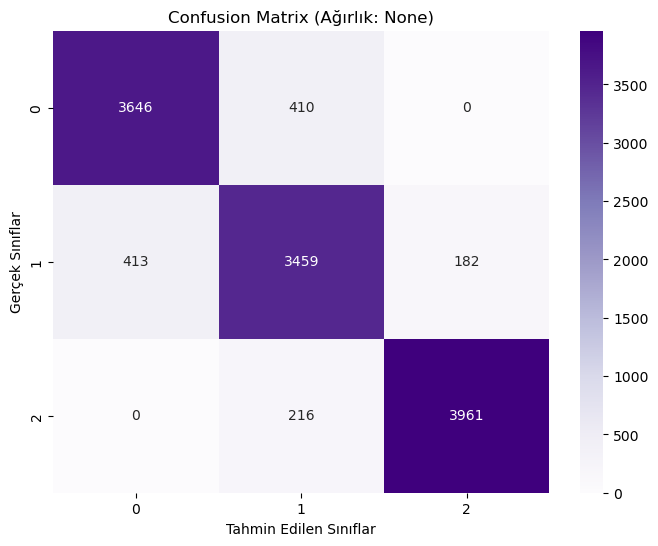

In [27]:
from sklearn.model_selection import GridSearchCV

# 1. Denenecek Ağırlık Kombinasyonları
# Class 0 ve 2'yi "1" (standart) tutuyoruz, Class 1'i artırıyoruz.
weights_to_try = [
    None,                       # Varsayılan (Eşit Ağırlık)
    {0: 1.0, 1: 1.2, 2: 1.0},   # Class 1'e %20 daha fazla önem ver
    {0: 1.0, 1: 1.5, 2: 1.0},   # Class 1'e %50 daha fazla önem ver
    {0: 1.0, 1: 2.0, 2: 1.0},   # Class 1'e 2 kat önem ver
    {0: 1.0, 1: 3.0, 2: 1.0}    # (Opsiyonel) Çok zorlarsak ne olur?
]

# 2. Parametre Izgarası
param_grid = {
    'class_weight': weights_to_try,
    'C': [0.1, 1],       # Önceki adımdan gelen en iyi C değerleri
    'solver': ['lbfgs']  
}


# 'scoring' olarak 'recall_macro' seçebiliriz ki model azınlık/zor sınıfı yakalamaya odaklansın
# Veya genel başarı için 'accuracy' kullanabilirsin. Şimdilik 'f1_weighted' ile denge arayalım.
grid_search_weights = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted', # Hem precision hem recall dengesine bakar
    n_jobs=-1,
    verbose=1
)

grid_search_weights.fit(X_train_scaled, y_train)

# 4. En İyi Sonuçlar
print(f"\nEn İyi Ağırlık Ayarı: {grid_search_weights.best_params_['class_weight']}")
print(f"\nEn İyi C Değeri: {grid_search_weights.best_params_['C']}")

print(f"En İyi Skor: %{grid_search_weights.best_score_*100:.4f}")

# 5. Test Seti Üzerinde Final Kontrol
best_weighted_model = grid_search_weights.best_estimator_
y_pred_weighted = best_weighted_model.predict(X_test_scaled)

print("\nAĞIRLIKLI LOGISTIC REGRESSION SONUCU")
print(classification_report(y_test, y_pred_weighted))

# 6. Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_weighted), annot=True, fmt='d', cmap='Purples')
plt.title(f"Confusion Matrix (Ağırlık: {grid_search_weights.best_params_['class_weight']})")
plt.ylabel('Gerçek Sınıflar')
plt.xlabel('Tahmin Edilen Sınıflar')
plt.show()

## 5. Katsayı Analizi (Feature Importance)

Logistic Regression modelinin karar verirken hangi özelliklere (feature) pozitif veya negatif anlamda en çok önem verdiğini görselleştiriyoruz. Bu analiz, özellikle **Class 1 (Orta Seviye)** için belirleyici faktörleri anlamamızı sağlar.

/var/folders/bx/flr0_6zx1f9b8ydzct1qv_6m0000gn/T/ipykernel_2401/3909193162.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='coolwarm')


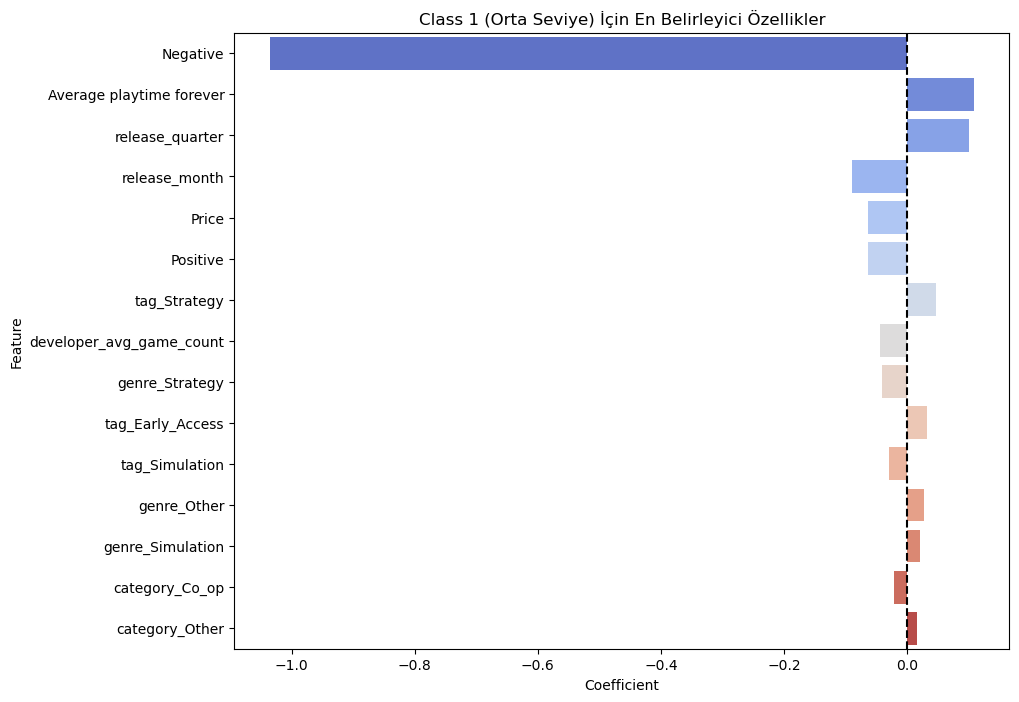

In [28]:
# Class 1 için katsayıları al
coefficients = best_weighted_model.coef_[1] 
features = X.columns

# DataFrame oluştur
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()

# En etkili 15 özelliği seç
top_features = feature_importance.sort_values(by='Abs_Coefficient', ascending=False).head(15)

# Grafik Çiz
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='coolwarm')
plt.title('Class 1 (Orta Seviye) İçin En Belirleyici Özellikler')
plt.axvline(0, color='black', linestyle='--')
plt.show()

In [29]:
# 1. Feature Engineering Fonksiyonu
def apply_feature_engineering(df):
    df_fe = df.copy()
    
    # A. Kalite Puanı (Quality Score)
    # Olumlu yorumların toplam yorumlara oranı (0-1 arası)
    # Paydaya +1 ekliyoruz ki 0'a bölünme hatası olmasın
    df_fe['Quality_Score'] = df_fe['Positive'] / (df_fe['Positive'] + df_fe['Negative'] + 1)
    
    # B. Fiyat/Performans Skoru (Value Score)
    # Oynanış süresi başına ödenen ücret gibi düşünülebilir (Tersi: Bir dolar başına kaç saat oynanıyor)
    # Price + 1 diyerek ücretsiz oyunlarda hata almayı engelliyoruz.
    df_fe['Value_Score'] = df_fe['Average playtime forever'] / (df_fe['Price'] + 1)
    
    # C. Toplam Etkileşim (Review Volume - Log Transformlu)
    # Çok aşırı yorum alan oyunlar (Outlier) dengeyi bozmasın diye Log alıyoruz.
    df_fe['Review_Volume'] = np.log1p(df_fe['Positive'] + df_fe['Negative'])
    
    return df_fe

# 2. Mevcut X_train ve X_test verisine uygula
X_train_fe = apply_feature_engineering(X_train)
X_test_fe = apply_feature_engineering(X_test)

# 3. Yeni Özellikleri Ölçeklendir (Scaling)
# Yeni sütunlar geldiği için scaler'ı tekrar fit etmeliyiz
scaler_fe = StandardScaler()
X_train_fe_scaled = scaler_fe.fit_transform(X_train_fe)
X_test_fe_scaled = scaler_fe.transform(X_test_fe)

# 4. Modeli Tekrar Eğit (En iyi ağırlıklarla: {0: 1.0, 1: 1.2, 2: 1.0})
# Daha önce bulduğumuz en iyi ağırlığı kullanıyoruz
best_weights = {0: 1.0, 1: 1.2, 2: 1.0}

model_fe = LogisticRegression(
    class_weight=best_weights,
    random_state=42,
    max_iter=1000,
    solver='lbfgs'
)

print("Yeni özelliklerle model eğitiliyor...")
model_fe.fit(X_train_fe_scaled, y_train)

# 5. Sonuçları Gör
y_pred_fe = model_fe.predict(X_test_fe_scaled)

print("\nFEATURE ENGINEERING + AĞIRLIKLI LOGISTIC REGRESSION SONUCU")
print(f"Doğruluk (Accuracy): %{accuracy_score(y_test, y_pred_fe)*100:.2f}")
print("-" * 60)
print(classification_report(y_test, y_pred_fe))

# 6. Hangi Özellik İşe Yaradı? (Katsayı Kontrolü)
# Yeni eklediğimiz özelliklerin etkisine bakalım
new_features = ['Quality_Score', 'Value_Score', 'Review_Volume']
indices = [X_train_fe.columns.get_loc(c) for c in new_features]
coefs = model_fe.coef_[1][indices] # Class 1 için katsayılar

print("\nYeni Özelliklerin Etkisi (Class 1 İçin):")
for feat, coef in zip(new_features, coefs):
    print(f"{feat}: {coef:.4f} {'(Pozitif Etki)' if coef > 0 else '(Negatif Etki)'}")


Yeni özelliklerle model eğitiliyor...

FEATURE ENGINEERING + AĞIRLIKLI LOGISTIC REGRESSION SONUCU
Doğruluk (Accuracy): %91.06
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      4056
           1       0.85      0.88      0.87      4054
           2       0.96      0.95      0.95      4177

    accuracy                           0.91     12287
   macro avg       0.91      0.91      0.91     12287
weighted avg       0.91      0.91      0.91     12287


Yeni Özelliklerin Etkisi (Class 1 İçin):
Quality_Score: -1.2671 (Negatif Etki)
Value_Score: -0.0518 (Negatif Etki)
Review_Volume: -7.7252 (Negatif Etki)


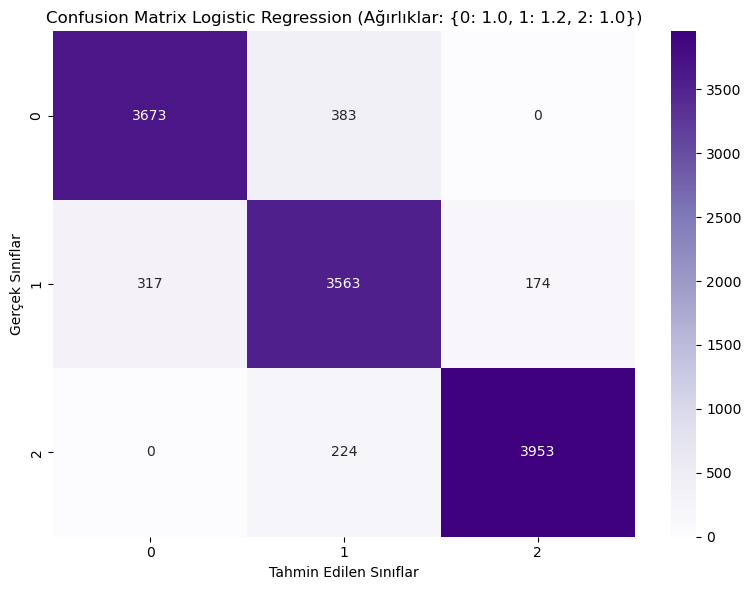

In [30]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))

cm = confusion_matrix(y_test, y_pred_fe)

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=model_fe.classes_,
    yticklabels=model_fe.classes_
)

plt.title(f"Confusion Matrix Logistic Regression (Ağırlıklar: {best_weights})")
plt.ylabel('Gerçek Sınıflar')
plt.xlabel('Tahmin Edilen Sınıflar')
plt.tight_layout()
plt.show()


## 5. Feature Engineering (Öznitelik Mühendisliği) ve Final Model
Katsayı analizinden (Coefficient Analysis) elde ettiğimiz içgörüler, modelin özellikle Yorum Sayıları (Reviews) ve Oynanış Süresi (Playtime) gibi değişkenlere odaklandığını göstermiştir.

Logistic Regression lineer bir model olduğu için, değişkenler arasındaki oranları (örneğin; Fiyat/Performans veya Memnuniyet Oranı) kendiliğinden öğrenemez. Bu aşamada, modele yardımcı olmak adına 3 yeni "Süper Özellik" türetilmiştir:

  Eklenen Yeni Özellikler

- Quality_Score (Kalite Puanı):

- Formül: Positive / (Positive + Negative)

- Amaç: Sadece yorum sayısına değil, oyuncu memnuniyet oranına odaklanmak.

- Value_Score (Fiyat/Performans Skoru):

- Formül: Average Playtime / (Price + 1)

Amaç: "Ucuz ama çok oynanan" (Fiyat/Performans canavarı) oyunları tespit etmek.

Review_Volume (Popülarite - Log Transform):

Formül: Log(Positive + Negative)

Amaç: Oyunun ne kadar "Göz önünde" olduğunu (Hype) ölçmek. Aykırı değerleri bastırmak için logaritmik dönüşüm uygulanmıştır.

Analiz sonucunda Review_Volume ve Quality_Score özelliklerinin Class 1 üzerindeki etkisinin Negatif (-) olduğu görülmüştür.

Yorum: Bu durum, oyunun popülaritesi ve kalitesi aşırı arttığında, oyunun "Orta Seviye" (Class 1) liginden çıkıp "Başarılı/Efsane" (Class 2) ligine terfi ettiğini gösterir.

Model, bu özellikleri kullanarak Class 1 ile Class 2 arasındaki ince çizgiyi başarıyla öğrenmiştir.